In [6]:
# === project setup ===
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
print("PROJECT_ROOT =", PROJECT_ROOT)

if not (PROJECT_ROOT / "src").exists():
    raise RuntimeError("src directory not found — wrong PROJECT_ROOT")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROJECT_ROOT = C:\Users\hodor\Documents\lab-MSU\Works\analysis_tools


In [4]:
# === imports ===
from h5py import File 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import copy
import importlib
import pandas as pd
import h5py

In [7]:
from src.utils.parse_h5df import * 
from src.utils.fb_quasi_parse_events import reparse_trigger_v1_1, trigger_to_event_v1_1
from src.utils.events import * 
from src.utils.spectral_analysis import *
from src.utils.transformations import unit_to_db
from src.utils.montage_processing import *
from src.utils.rereferencing import *

In [37]:
# from src.utils.montage_processing import get_good_channels

def get_good_channels(fl_montage, radius=0.54):
    df = pd.read_csv(fl_montage, sep='\t')

    return df.loc[(df.radius <= radius) & (df.labels != "FC6")]["labels"].values

In [33]:
from src.utils.CSP import calculate_CSP

In [11]:
from src.visualization.plot_signal import plot_signal
from src.visualization.plot_csp_components import plot_CSP_components

In [12]:
DATA_FOLDER = r"..\data"
RECORD = "OM-push_full_typed.h5"

In [38]:
EEG_CHANNELS = np.arange(64)
CED_FILE = r"../resources/mks64_standard.ced"

ch_labels = get_channel_names(CED_FILE)
positions = get_topo_positions(CED_FILE)

labels_ROA = ["FC5", "FC3", "FC1", "C1", "CP1", "CP3", "CP5", "C5", "C3"] # mu rhythm
idxs_ROA = [find_ch_idx(ch, CED_FILE) for ch in labels_ROA]

good_channels = get_good_channels(CED_FILE, radius=0.54)
idxs_good_channels = np.array([find_ch_idx(ch, CED_FILE) for ch in good_channels])

ch_labels = ch_labels[idxs_good_channels]
positions = positions[idxs_good_channels]

Fs = 1000 # Hz
s_to_idx = lambda x: int(x * Fs)
ms_to_idx = lambda x: int(x // 1000 * Fs)

In [39]:
good_channels

<StringArray>
[ 'T7',  'P7', 'CP5',  'F7', 'FC5',  'F3',  'P3',  'C3', 'CP1',  'O1', 'Fp1',
 'FC1',  'Fz', 'Fp2',  'Cz', 'FC2', 'CP2',  'Pz',  'O2',  'Oz',  'C4',  'P4',
  'F4',  'F8', 'CP6',  'P8',  'T8', 'FT7', 'TP7', 'AF7',  'F5',  'C5', 'FC3',
 'CP3',  'P5', 'PO3', 'PO7',  'C1',  'P1', 'AF3',  'F1', 'AF4', 'Fpz', 'FCz',
  'F2', 'CPz',  'C2', 'POz',  'P2', 'PO8', 'PO4',  'P6', 'CP4', 'FC4',  'C6',
  'F6', 'AF8', 'FT8', 'TP8']
Length: 59, dtype: str

In [42]:
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('jet')
newcmp = ListedColormap(viridisBig(np.linspace(0, 1, 15)))

In [41]:
# === data ===
path = os.path.join(DATA_FOLDER, RECORD)
with h5py.File(path, "r") as h5f:
    data = h5f["eeg/data"][:]
data.shape

(404544, 65)

In [43]:
# bandpass filter
raw_eeg = data[:, idxs_good_channels] * 1E6 # uV
filt_eeg = bandpass_filter(raw_eeg, fs=Fs, low=0.5, high=40)

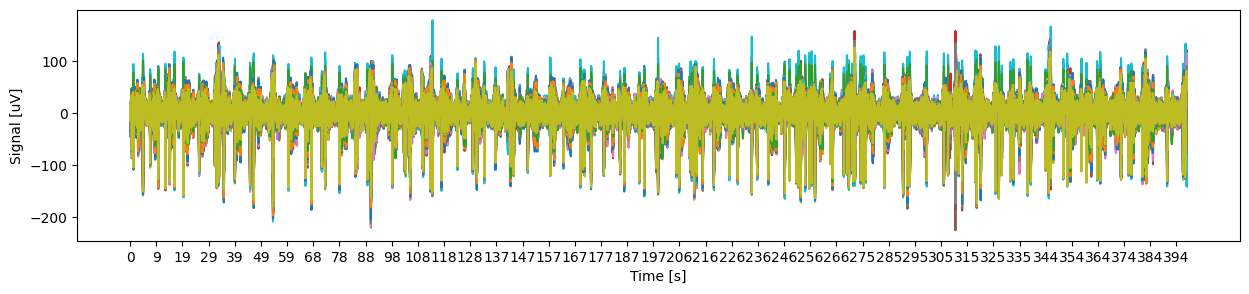

In [44]:
start_s, end_s = 0, raw_eeg.shape[0] // Fs 
plot_signal(start_s, end_s, filt_eeg, s_to_idx, plot=True)  # plot all channels

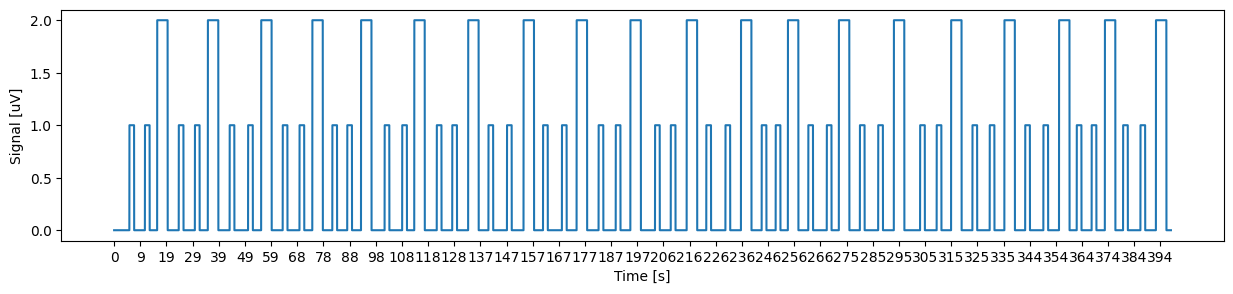

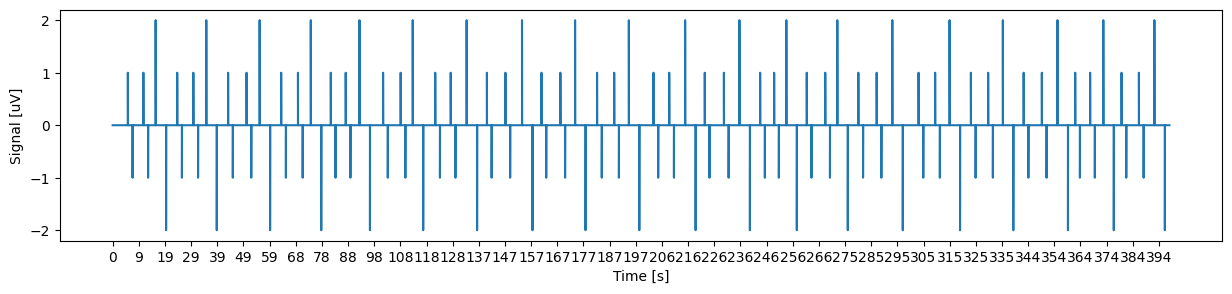

In [45]:
trigger = data[:, -1]
plot_signal(start_s, end_s, data[:, -1], s_to_idx, plot=False)  # plot all channels
plot_signal(start_s, end_s, np.diff(trigger), s_to_idx, plot=True)

In [46]:
trigger_diff = np.diff(trigger)
mask_motor_start = np.where(trigger_diff == 1)[0].tolist()
mask_motor_finish = np.where(trigger_diff == -1)[0].tolist()
mask_rest_start = np.where(trigger_diff == 2)[0].tolist()
mask_rest_finish = np.where(trigger_diff == -2)[0].tolist()

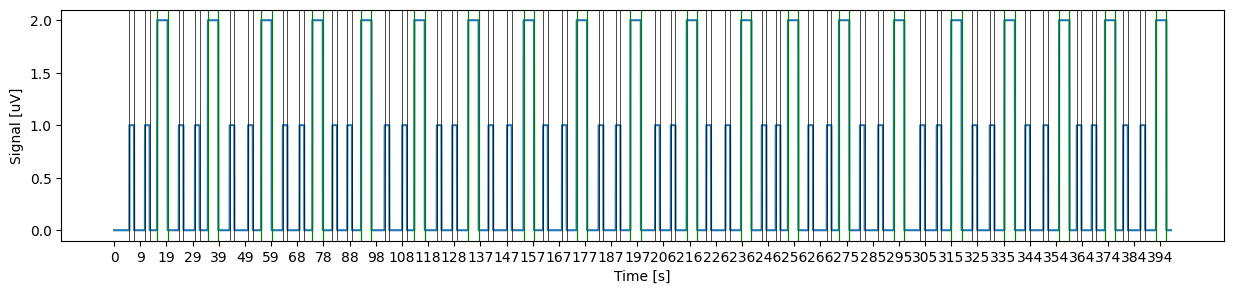

In [47]:
plot_signal(start_s, end_s, trigger, s_to_idx, plot=False)
for epoch_start in mask_motor_start + mask_motor_finish:
    plt.axvline(epoch_start, color="black", linewidth=0.5)
for epoch_start in mask_rest_start + mask_rest_finish:
    plt.axvline(epoch_start, color="green", linewidth=0.85)

In [48]:
def cut_epoch(mask_start, mask_finish, data):
    epochs = []
    for start, end in zip(mask_start, mask_finish):
        epochs.append(data[start:end])
    return np.array(epochs)

epochs_motor = cut_epoch(mask_motor_start, mask_motor_finish, filt_eeg)
epochs_rest = cut_epoch(mask_rest_start, mask_rest_finish, filt_eeg)
epochs_motor.shape, epochs_rest.shape

((40, 1800, 59), (20, 4000, 59))

In [49]:
data_motor = epochs_motor.reshape(-1, epochs_motor.shape[2])
data_rest = epochs_rest.reshape(-1, epochs_rest.shape[2])
data_motor.shape, data_rest.shape

((72000, 59), (80000, 59))

In [50]:
# === CSP === 
from scipy.linalg import eigh
from mne.viz import plot_topomap
import matplotlib.gridspec as gridspec

In [51]:
from sklearn.covariance import MinCovDet

def cov_robust_mcd(X):
    """
    X: np.array (n_samples, n_channels )
    Возвращает робастную ковариационную матрицу
    """
    # sklearn ожидает (n_samples, n_features), поэтому транспонируем
    mcd = MinCovDet().fit(X.T)
    return mcd.covariance_

In [84]:
# Anatoly Method
def cov_epoch(X):
    """
    X: (channels, time)
    """
    C = X @ X.T
    return C / np.trace(C)

def regularize(C, alpha=0.05):
    return (1 - alpha) * C + alpha * np.eye(C.shape[0])

def regularize_shrinkage(C, alpha=0.05):
    # Среднее по диагонали (сферическая матрица)
    C_sphere = np.trace(C) / C.shape[0] * np.eye(C.shape[0])
    
    # Shrinkage регуляризация
    C_reg = (1 - alpha) * C + alpha * C_sphere
    return C_reg

def compute_csp_concat(X1, X2, n_components=2):
    """
    CSP с объединением всех эпох каждого класса.
    
    X1, X2: данные классов (n_epochs, n_samples, n_channels)
    n_components: сколько фильтров брать с каждой стороны
    """
    # Транспонируем и объединяем все эпохи по времени (чтобы получилось n_channels x total_samples)
    X1_all = np.hstack([epoch.T for epoch in X1])  # n_channels x (n_epochs * n_samples)
    X2_all = np.hstack([epoch.T for epoch in X2])
    
    # Нормированная ковариация
    def cov_norm(X):
        cov = X @ X.T
        return cov / np.trace(cov)
    
    C1 = cov_norm(X1_all) 
    C2 = cov_norm(X2_all)

    # C1 = cov_robust_mcd(X1_all)
    # C2 = cov_robust_mcd(X2_all)

    C1 = regularize_shrinkage(C1, alpha=0.1)
    C2 = regularize_shrinkage(C2, alpha=0.1)
       
    # Обобщённая задача собственных значений
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(C1 + C2) @ C1)
    
    # сортируем по убыванию собственных значений, первые - лучшие 
    ix = np.argsort(eigvals)[::-1]  # убывание λ
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    ## spatial patterns 
    A = np.linalg.pinv(C1 + C2) @ eigvecs
    A /= np.linalg.norm(A, axis=0, keepdims=True) # to normalize

    return eigvals, eigvecs, A

# eigvals, eigvecs, A = compute_csp_concat(epochs_motor, epochs_rest)

In [85]:

def plot_CSP_components(eigvals, A, positions, ch_labels, row_idx, gs, fig):
        # первый график: линия eigenvalues
        ax0 = plt.subplot(gs[row_idx, 0])
        ax0.plot(eigvals, "k")
        ax0.scatter(range(len(eigvals)), eigvals, marker="o", s=20)
        ax0.set_ylim(0, 1)
        ax0.set_title("Eigenvalues")
        
        # топоплоты
        ims = []
        idxs = [0, 1, 2, 3, -4, -3, -2, -1]
        vmin = np.min(A[idxs])
        vmax = np.max(A[idxs])
        vmin, vmax = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
        
         # топографические карты
        def plot_topoplot(X, positions, vmin=None, vmax=None, ch_labels=None, axes=None):
                im, cn = plot_topomap(X, positions,  image_interp='cubic', ch_type='eeg', names =ch_labels,
                        size=5, show=False, contours=0, sphere=0.5, 
                        cmap=newcmp, extrapolate='head', axes=axes, vlim=[vmin, vmax])
                return im
        
        for i, idx in enumerate(idxs):
                ax_map = plt.subplot(gs[row_idx, i+1])
                im = plot_topoplot(A[idx], positions, axes=ax_map, 
                        vmin=vmin, vmax=vmax)
                comp_number = idx if idx >= 0 else len(ch_labels)+idx
                ax_map.set_title(f"CSP #{comp_number+1}")
                ims.append(im)

        # общий colorbar справа от последнего topomap
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax_map)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(ims[-1], cax=cax)
        cbar.set_ticks([vmin, vmax])
        cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])
        cbar.ax.yaxis.set_tick_params(labelsize=10)

8-30 Hz -- done.
8-13 Hz -- done.
9-13 Hz -- done.
10-14 Hz -- done.
11-15 Hz -- done.


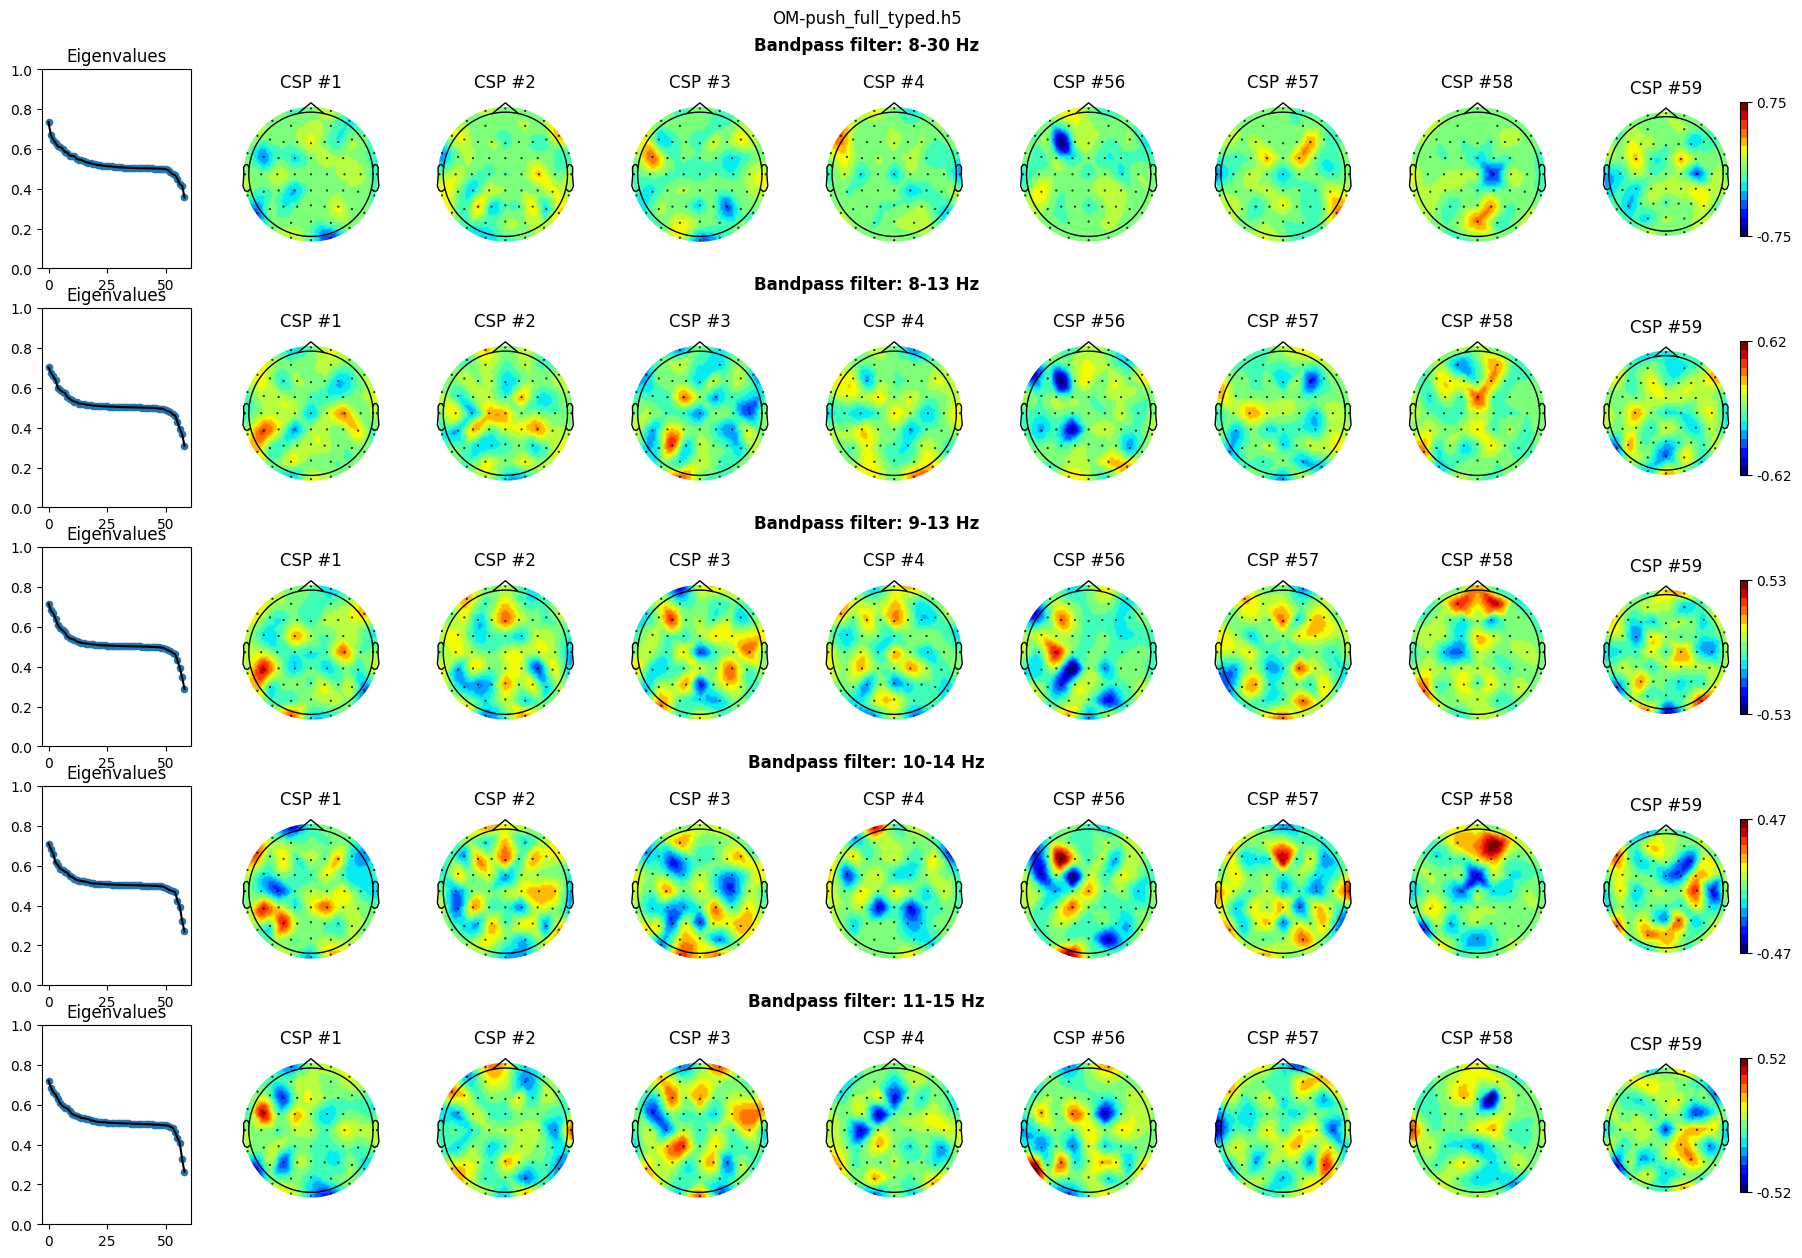

In [86]:
bands = [[8, 30], [8, 13] , [9, 13], [10, 14], [11, 15]]

fig = plt.figure(figsize=(22, 3 * len(bands)))
gs = gridspec.GridSpec(len(bands), 9, height_ratios=[1]*len(bands), wspace=0.3)

for row_idx, (low_f, high_f) in enumerate(bands):
    filt_eeg = bandpass_filter(raw_eeg, fs=Fs, low=low_f, high=high_f)
    epochs_motor = cut_epoch(mask_motor_start, mask_motor_finish, filt_eeg)
    epochs_rest = cut_epoch(mask_rest_start, mask_rest_finish, filt_eeg)
    
    # eigvals, eigvecs, A = calculate_CSP(epochs_motor, epochs_rest)
    eigvals, eigvecs, A = compute_csp_concat(epochs_motor, epochs_rest)
    
    plot_CSP_components(eigvals, A, positions, ch_labels, row_idx, gs, fig)

    # Добавляем название полосы **над всей строкой**
    ax0 = plt.subplot(gs[row_idx, 0])
    pos = ax0.get_position()  # BBox

    # Добавляем название полосы
    fig.text(0.5, pos.y1 + 0.01, f"Bandpass filter: {low_f}-{high_f} Hz",
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    

    print(f"{low_f}-{high_f} Hz -- done.")
plt.suptitle(RECORD, y=0.92)
plt.show()

In [1]:
def cov_epoch(X):
    """
    X: (channels, time)
    """
    C = X @ X.T
    return C / np.trace(C)

def calculate_CSP(epochs_motor, epochs_rest):
    covs_motor = np.array([cov_epoch(ep.T) for ep in epochs_motor])  # ep: (time, ch)
    C_motor  = covs_motor.mean(axis=0)
    C_motor  = regularize(C_motor,  alpha=0.05)

    covs_rest = np.array([cov_epoch(ep.T) for ep in epochs_rest])  # ep: (time, ch)
    C_rest  = covs_rest.mean(axis=0)
    C_rest = regularize(C_rest, alpha=0.05)
    
    C_sum = C_motor + C_rest
    eigvals, eigvecs = eigh(C_motor, C_sum)     # λ = 1 -> motor class
    
    # сортируем по убыванию собственных значений, первые - лучшие 
    ix = np.argsort(eigvals)[::-1]  # убывание λ
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    ## spatial patterns 
    A = C_sum @ eigvecs
    A /= np.linalg.norm(A, axis=0, keepdims=True) # to normalize

    return eigvals, eigvecs, A

In [2]:
bands = [[8, 30], [8, 12], [9, 13], [10, 14], [11, 15]]

fig = plt.figure(figsize=(22, 3 * len(bands)))
gs = gridspec.GridSpec(len(bands), 9, height_ratios=[1]*len(bands), wspace=0.3)

for row_idx, (low_f, high_f) in enumerate(bands):
    filt_eeg = bandpass_filter(raw_eeg, fs=Fs, low=low_f, high=high_f)
    epochs_motor = cut_epoch(mask_motor_start, mask_motor_finish, filt_eeg)
    epochs_rest = cut_epoch(mask_rest_start, mask_rest_finish, filt_eeg)
    
    eigvals, eigvecs, A = calculate_CSP(epochs_motor, epochs_rest)
    
    plot_CSP_components(eigvals, A, positions, ch_labels, row_idx, gs, fig)

    # Добавляем название полосы **над всей строкой**
    ax0 = plt.subplot(gs[row_idx, 0])
    pos = ax0.get_position()  # BBox

    # Добавляем название полосы
    fig.text(0.5, pos.y1 + 0.01, f"Bandpass filter: {low_f}-{high_f} Hz",
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    

    print(f"{low_f}-{high_f} Hz -- done.")
plt.suptitle(RECORD, y=0.92)
plt.show()

NameError: name 'plt' is not defined